# Effect of FIFA Ratings on Team Model

In [1]:
from airsenal.framework.utils import NEXT_GAMEWEEK, session
from airsenal.framework.bpl_interface import (
    get_fitted_team_model,
    get_result_df,
    create_and_fit_team_model,
)
from airsenal.framework.season import CURRENT_SEASON, get_teams_for_season

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
season = CURRENT_SEASON
gameweek = NEXT_GAMEWEEK

teams = get_teams_for_season(season, session)

## Normal Model with FIFA Ratings as Covariates

In [3]:
model_fifa = get_fitted_team_model(season, gameweek, session)

Fitting team model...


In [4]:
def plot_team_ratings(model):
    # extract indices of current premier league teams
    # val-1 because 1-indexed in model but 0-indexed in python
    current_idx = {key: val-1 for key, val in model.team_indices.items()
                   if key in teams}

    a_mean = model.a.mean(axis=0)
    b_mean = model.b.mean(axis=0)

    a_conf95 = np.abs(np.quantile(model.a,[0.025, 0.975], axis=0) - a_mean)
    b_conf95 = np.abs(np.quantile(model.b, [0.025, 0.975], axis=0) - b_mean)
    a_conf80 = np.abs(np.quantile(model.a,[0.1, 0.9], axis=0) - a_mean)
    b_conf80 = np.abs(np.quantile(model.b, [0.1, 0.9], axis=0) - b_mean)

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(aspect='equal')
    plt.errorbar(a_mean[list(current_idx.values())],
                 b_mean[list(current_idx.values())],
                 xerr=a_conf80[:, list(current_idx.values())],
                 yerr=b_conf80[:, list(current_idx.values())],
                 marker='o', markersize=10,
                 linestyle='', linewidth=0.5)
    plt.xlabel('Attack (~Rate Goals Scored)', fontsize=14)
    plt.ylabel('Defence (~Rate Goals Conceded)', fontsize=14)

    for team, idx in current_idx.items():
        ax.annotate(team,
                    (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                    fontsize=12)


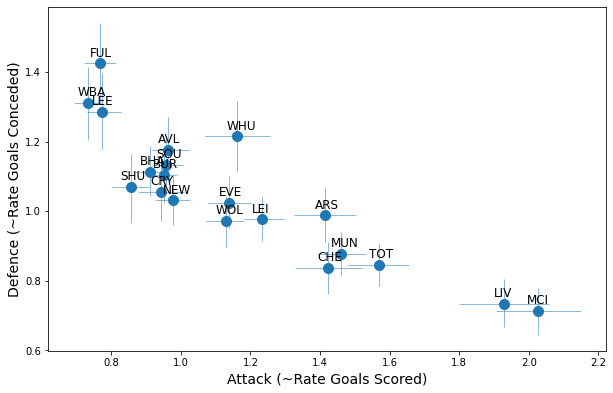

In [5]:
plot_team_ratings(model_fifa)

## Model without FIFA Ratings as Covariates

In [6]:
df_team = get_result_df(season, gameweek, session)
df_X = None
model_nofifa = create_and_fit_team_model(df_team, None, teams=teams)

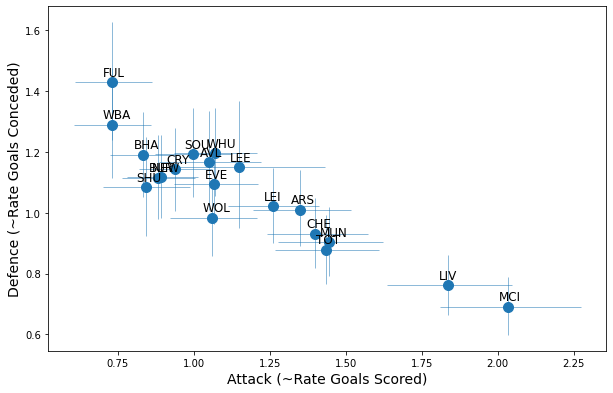

In [7]:
plot_team_ratings(model_nofifa)

## Difference

In [8]:
a_fifa = model_fifa.a.mean(axis=0)
b_fifa = model_fifa.b.mean(axis=0)

a_nofifa = model_nofifa.a.mean(axis=0)
b_nofifa = model_nofifa.b.mean(axis=0)

a_diff = a_fifa - a_nofifa
b_diff = b_fifa - b_nofifa

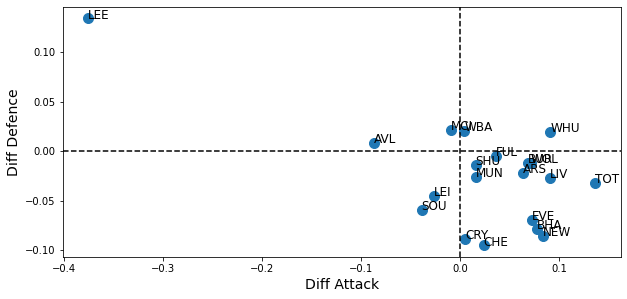

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(aspect='equal')

current_idx = {key: val-1 for key, val in model_fifa.team_indices.items()
               if key in teams}

plt.plot(
    a_diff[list(current_idx.values())],    
    b_diff[list(current_idx.values())],
    marker='o', markersize=10,
    linestyle='', linewidth=0.5
)
plt.xlabel('Diff Attack', fontsize=14)
plt.ylabel('Diff Defence', fontsize=14)

for team, idx in current_idx.items():
    ax.annotate(team,
                (a_diff[idx], b_diff[idx]), 
                fontsize=12)

plt.axvline(0, color="k", linestyle="--")
plt.axhline(0, color="k", linestyle="--")

- Diff Attack > 0: Including FIFA ratings causes team to have a stronger attack.
- Diff Defence > 0: Including FIFA ratings causes team to have a weaker defence.